# Digital Circuits

## Boolean algebra

## Schedule:

- Boolean algebra
- Axiomatic definition
- Logic gates
- Postulates and theorems
- **Boolean functions**
- Logic diagrams with gates
- Simplification of literals or algebraic manipulation
- Complementing a function
- Canonical and normalized forms
- Minimum and maximum terms
- Karnaugh map

In [1]:
# Run this only in Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
colab_path = '/content/drive/MyDrive/Colab Notebooks/digilab/notebooks/img/'
my_path = 'img/'
valid_path = colab_path # Use one of them depending on the platform

## Boolean functions

Bool or Boolean functions are expressions formed by binary variables, binary operators and the sign $=$.

- **Priority:** $\left(\:\right)\longrightarrow NOT\longrightarrow AND\longrightarrow OR$

### Example:

$$F_{1}=xy\overline{z}$$

In this example, the function $F_1$ = 1 only if $x = 1$, $y = 1$ and $z = 0$. In any other case $F_1 = 0$.

This function, like any other, can be represented by a truth table:

In [3]:
from IPython.display import SVG
SVG(valid_path + 'bool04.svg')

### Example:

$$F_{2}=x+\overline{y}z$$

This function is activated in two cases, when $x =1$ (regardless of $y$, $z$), or when $y = 0$ and $z = 1$ (regardless of $x$). The truth table looks like this:

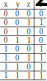

In [4]:
SVG(valid_path + 'bool05.svg')

### Example:

$$F_{3}=\overline{x}\overline{y}z+\overline{x}yz+x\overline{y}$$

There are three cases to consider in this example:

In [5]:
SVG(valid_path + 'bool06.svg')

In truth tables, the number of rows is equal to $2^n$, where $n$ is the number of variables in the function.

We're going to work on Boolean functions with a small Python library.

<code>
  from boolean_equation import *
</code>

In [6]:
from abc import ABC, abstractmethod

class LogicError(Exception):
    pass

class UnknownStateError(LogicError):
    pass

class StateChangeUnableError(LogicError):
    pass

class InvalidOperandError(LogicError):
    pass

def parse(operand) -> 'Node':
    '''Parse to actual Node'''
    if isinstance(operand, int) or isinstance(operand, bool):
        return Const(operand)
    elif isinstance(operand, str):
        while operand.startswith('~~'):
            operand = operand[2:]
        if operand.startswith('~'):
            return Not(Var(operand[1:]))
        else:
            return Var(operand)
    elif isinstance(operand, Node):
        return operand
    else:
        return InvalidOperandError("The following operand isn't based on Node and can't be changed to Const(): %s" % repr(operand))

def _operandGenerator(operands):
    '''
    Generate guaranteed list of operands based on Node.
    Attempts to parse other types or raises InvalidOperandError!
    '''
    for operand in operands:
        yield parse(operand)

def isUnknown(node):
    try:
        node.state()
        return False
    except UnknownStateError:
        return True

class Node(ABC):
    def __init__(self):
        # Other Nodes that this class contains/depends upon
        self.operands = []

    @abstractmethod
    def state(self) -> bool:
        pass

    @abstractmethod
    def set_state(self, newState: bool):
        pass

    def __bool__(self) -> bool:
        return bool(self.state())

    def __or__(self, other) -> 'Node':
        # Would work without this assert, but allow dumb operator pairs like in JS
        assert isinstance(other, Node)

        if isinstance(self, Or) and isinstance(other, Or):
            return Or(*self.operands, *other.operands)
        elif isinstance(self, Or):
            return Or(*self.operands, other)
        elif isinstance(other, Or):
            return Or(self, *other.operands)
        else:
            return Or(self, other)

    def __and__(self, other) -> 'Node':
        # Would work without this assert, but allow dumb operator pairs like in JS
        assert isinstance(other, Node)

        if isinstance(self, And) and isinstance(other, And):
            return And(*self.operands, *other.operands)
        elif isinstance(self, And):
            return And(*self.operands, other)
        elif isinstance(other, And):
            return And(self, *other.operands)
        else:
            return And(self, other)

    def __invert__(self) -> 'Node':
        return Not(self)

class Var(Node):
    def __init__(self, name: str, state=None):
        '''
        state=None: Unknown value which prevents equation
                    from getting solved.
        '''
        Node.__init__(self)
        assert('"' not in name)
        assert('"' not in name)
        assert(' ' not in name)
        assert('\t' not in name)
        assert('=' not in name)
        self.name = name
        if state is None:
            self._state = None
        else:
            self._state = bool(state)

    def state(self) -> bool:
        if self._state is None:
            raise UnknownStateError("Variable '%s' isn't known, which prevents solving the equation!" % self.name)
        return bool(self._state)

    def set_state(self, newState: bool):
        self._state = newState

    def __repr__(self):
        if self._state is None:
            return "Var('%s')" % self.name
        else:
            return "Var('%s', %s)" % (self.name, bool(self.state()))

    def __str__(self):
        if self._state is None:
            return '%s=?' % self.name
        else:
            return '%s=%s' % (self.name, int(self.state()))

class Const(Node):
    def __init__(self, state: bool):
        Node.__init__(self)
        if state is None:
            raise InvalidOperandError('Const has to be termined!')
        self._state = bool(state)

    def state(self) -> bool:
        return self._state

    def set_state(self, newState: bool):
        if newState != self._state:
            raise StateChangeUnableError("Can't change value of constant!!!")

    def __repr__(self):
        return "Const(%s)" % bool(self.state())

    def __str__(self):
        return str(int(self.state()))

class And(Node):
    def __init__(self, *operands):
        Node.__init__(self)
        if len(operands) == 0:
            raise InvalidOperandError('Or needs to have at least one operand. None given')
        self.operands = list(_operandGenerator(operands))

    def state(self) -> bool:
        totalCount, trueCount, unknownCount = 0, 0, 0
        for operand in self.operands:
            totalCount += 1
            try:
                if operand.state():
                    trueCount += 1
                else:
                    return False
            except UnknownStateError:
                unknownCount += 1

        if trueCount == totalCount:
            return True
        if unknownCount > 0:
            raise UnknownStateError("Can't determine state of AND-Equation: %s" % repr(self))

    def set_state(self, newState: bool):
        # Ignore if state is already guarenteed to be the target one
        try:
            if self.state() == newState:
                return
        except UnknownStateError:
            pass

        if newState:
            # Goal: All operands have to be true to guarantee being true
            for operand in self.operands:
                operand.set_state(True)
        else:
            # Goal: Any value has to be false to guarantiee beeing false
            for operand in self.operands:
                try:
                    operand.set_state(False)
                    return
                except StateChangeUnableError:
                    pass

            # At this point no state could be set to false
            raise StateChangeUnableError("Can't get this AND-Equation to equal False: %s" % repr(self))

    def __repr__(self):
        return 'And(%s)' % ', '.join(map(lambda op: repr(op), self.operands))

    def __str__(self):
        return '(' + ' ^ '.join(map(lambda op: str(op), self.operands)) + ')'

class Or(Node):
    def __init__(self, *operands):
        '''
        All that matters is that there is ANY value that is True.
        Unknown values don't matter in that case.
        '''
        Node.__init__(self)
        if len(operands) == 0:
            raise InvalidOperandError('Or needs to have at least one operand. None given')
        self.operands = list(_operandGenerator(operands))

    def state(self) -> bool:
        totalCount, unknownCount, falseCount = 0, 0, 0
        for operand in self.operands:
            totalCount += 1
            try:
                if operand.state():
                    return True
                else:
                    falseCount += 1
            except UnknownStateError:
                unknownCount += 1

        if totalCount == (unknownCount + falseCount) and unknownCount > 0:
            raise UnknownStateError("Can't determine state of OR-Equation with no guarnteed outcome: %s" % repr(self))
        else:
            return False

    def set_state(self, newState: bool):
        # Ignore if state is already guarenteed to be the target one
        try:
            if self.state() == newState:
                return
        except UnknownStateError:
            pass

        if newState:
            # Goal: Make this equation return true (at least one value true to guarantee that)

            # Set next possible (changeable) state to true
            for operand in self.operands:
                try:
                    operand.set_state(True)
                    return
                except StateChangeUnableError:
                    pass
                break

            # Failed to change result of OR-Equation:
            raise StateChangeUnableError("Can't get this OR-Statement to equal True: %s" % repr(self))
        else:
            # Goal: Make this equation return false (all values false to guarantee that)

            # Try to make all known values false:
            for operand in self.operands:
                operand.set_state(False)

    def __repr__(self):
        return 'Or(%s)' % ', '.join(map(lambda op: repr(op), self.operands))

    def __str__(self):
        return '(' + ' v '.join(map(lambda op: str(op), self.operands)) + ')'

class Not(Node):

    def __init__(self, operand):
        self.operands = [ next(_operandGenerator((operand,))) ]

    def state(self) -> bool:
        return not self.operands[0].state()

    def set_state(self, newState: bool):
        try:
            if self.state() == newState:
                return
        except UnknownStateError:
            pass

        self.operands[0].set_state(not newState)

    def __repr__(self):
        return 'Not(%s)' % repr(self.operands[0])

    def __str__(self):
        operand = self.operands[0]
        if isinstance(operand, And) or isinstance(operand, Or) or isinstance(operand, Xor) \
            or isinstance(operand, Not) or isinstance(operand, Var) or isinstance(operand, Const):
            return '~%s' % operand
        else:
            return '~(%s)' % operand

class Xor(Node):
    def __init__(self, *operands):
        '''
        Excately two operators. One has to be true and one false.
        No excuses!
        '''
        Node.__init__(self)
        if len(operands) != 2:
            raise InvalidOperandError('Xor needs to have EXCATCLY two operands. Given: %s' % repr(operands))
        self.operands = list(_operandGenerator(operands))

    def state(self) -> bool:
        return self.operands[0].state() != self.operands[1].state()

    def set_state(self, newState: bool):
        # Ignore if state is already guarenteed to be the target one
        try:
            if self.state() == newState:
                return
        except UnknownStateError:
            pass

        if newState:
            for operands in [ self.operands, self.operands[::-1] ]:
                try:
                    op1, op2 = operands
                    op1.set_state(not op2.state())
                    return
                except (StateChangeUnableError, UnknownStateError):
                    pass

            op1, op2 = self.operands
            if isUnknown(op1) and isUnknown(op2):
                for val in [ False, True ]:
                    try:
                        op1.set_state(val)
                        op2.set_state(not val)
                        return
                    except StateChangeUnableError:
                        pass

            raise StateChangeUnableError("Can't make XOR-Equation to equal True: %s" % repr(self))
        else:
            for operands in [ self.operands, self.operands[::-1] ]:
                try:
                    op1, op2 = operands
                    op1.set_state(op2.state())
                    return
                except (StateChangeUnableError, UnknownStateError):
                    pass

            op1, op2 = self.operands
            if isUnknown(op1) and isUnknown(op2):
                for val in [ False, True ]:
                    try:
                        op1.set_state(val)
                        op2.set_state(val)
                        return
                    except StateChangeUnableError:
                        pass

            raise StateChangeUnableError("Can't make XOR-Equation to equal False: %s" % repr(self))


    def __repr__(self):
        return 'Xor(%s)' % ', '.join(map(lambda op: repr(op), self.operands))

    def __str__(self):
        return '(' + ' xor '.join(map(lambda op: str(op), self.operands)) + ')'

class Implication(Node):
    def __init__(self, a, b):
        Node.__init__(self)
        parsedA, parsedB = parse(a), parse(b)
        self.operands = [parsedA, parsedB]
        self.base = Or(Not(parsedA), parsedB)

    def state(self):
        return self.base.state()

    def set_state(self, new_state):
        return self.base.set_state(new_state)

    def __repr__(self):
        return 'Implication(%s, %s)' % (repr(self.operands[0]), repr(self.operands[1]))

    def __str__(self):
        return '%s \u2192 %s' % (str(self.operands[0]), str(self.operands[1]))

class Equivalent(Node):
    def __init__(self, a, b):
        Node.__init__(self)
        parsedA, parsedB = parse(a), parse(b)
        self.operands = [parsedA, parsedB]
        self.base = And(Implication(parsedA, parsedB), Implication(parsedB, parsedA))

    def state(self):
        return self.base.state()

    def set_state(self, new_state):
        return self.base.set_state(new_state)

    def __repr__(self):
        return 'Equivalent(%s, %s)' % (repr(self.operands[0]), repr(self.operands[1]))

    def __str__(self):
        return '%s \u2194 %s' % (str(self.operands[0]), str(self.operands[1]))

def Nor(*operands):
    return Not(Or(*operands))

def Nand(*operands):
    return Not(And(*operands))

def find_variables(operand):
    operands = [ operand ]
    while len(operands) > 0:
        operand = operands.pop()
        if isinstance(operand, Var):
            yield operand
        else:
            for suboperand in operand.operands:
                operands.append(suboperand)

def find_variable_state(operand, variable_name):
    state = None
    count = 0
    for variable in find_variables(operand):
        if variable.name != variable_name:
            continue

        count += 1
        if variable.state() is not state and state is not None:
            raise LogicError('The variable %s does not always has the same state!' % repr(variable_name))
        else:
            state = variable.state()

    if count == 0:
        raise LogicError('Variable %s could not be found.' % repr(variable_name))
    return state

def find_variable_state_or_default(operand, variable_name, default=None):
    try:
        return find_variable_state(operand, variable_name)
    except UnknownStateError:
        return default

def set_variable_state(operand, variable_name, new_state):
    for variable in find_variables(operand):
        if variable.name != variable_name:
            continue
        variable.set_state(new_state)

def print_lookup_table(*statements, sorted_variables=True):
    variable_names = list(set(map(lambda var: var.name, find_variables(statements[0]))))
    if sorted_variables:
        variable_names.sort()

    if len(statements) > 1:
        variable_name_sets = [ set(map(lambda var: var.name, find_variables(statement))) for statement in statements ]
        for prev_var_set, var_set in zip(variable_name_sets[:1], variable_name_sets[1:]):
            if prev_var_set != var_set:
                raise LogicError('Variable names are not matching for all given statements.')

    # Backup states
    orig_states = []
    for statement in statements:
        orig_states.append([ [name, find_variable_state_or_default(statement, name)] for name in variable_names ])

    # Header
    print('', *variable_names, sep=' | ', end='')
    for variable_name in variable_names:
        for statement in statements:
            set_variable_state(statement, variable_name, None)
    statement_strings = list(map(lambda s: str(s).replace('=?', ''), statements))
    print('', *statement_strings, sep=' | ')

    # Data
    cols = len(variable_names)
    states = [ [name, 0] for name in variable_names ]
    sameResults = True
    for row in range(2**len(variable_names)):
        for col, name in enumerate(variable_names):
            state = (row // (2**(cols - 1 - col))) % 2
            states[col][1] = state
            print(' | ', state, sep='', end='')
            print(' '*(len(name) - 1), end='')

        lastState = None

        for statement, statement_string in zip(statements, statement_strings):
            for state_data in states:
                set_variable_state(statement, state_data[0], state_data[1])
            state = int(statement.state())
            if lastState is not None and lastState != state:
                sameResults = False
            lastState = state
            print(' | ', state, sep='', end='')
            print(' '*(len(statement_string) - 1), end='')
        print()

    if len(statements) > 1:
        print('Same results: %s' % sameResults)

    # Restore states
    for statement, states in zip(statements, orig_states):
        for state_data in states:
            set_variable_state(statement, state_data[0], state_data[1])

def de_morgan(statement) -> Node:
    connHolder = None
    conn = statement
    while isinstance(conn, Not):
        connHolder = conn
        conn = conn.operands[0]

    negatedOperands = map(lambda o: Not(o), conn.operands)
    if isinstance(conn, And):
        oppositeConn = Not(Or(*negatedOperands))
    elif isinstance(conn, Or):
        oppositeConn = Not(And(*negatedOperands))
    else:
        raise LogicError('Invalid Note found for de morgan!')

    if connHolder is not None:
        connHolder.operands[0] = oppositeConn
    else:
        statement = oppositeConn

    return statement

In [7]:
# Definition of literals
x = Var('x')
y = Var('y')
z = Var('z')

In [8]:
# To write x' -> ~x
# AND: (x . y) -> And(x, y) == (x & y)
# OR: (x + y) -> Or(x, y) == (x | y)
F1 = And(x, y, ~z)
F2 = x | (~y & z)
F3 = And(~x, ~y, z) | And(~x, y, z) | And(x, ~y)

In [9]:
print(F1)

(x=? ^ y=? ^ ~z=?)


In [10]:
print(F2)

(x=? v (~y=? ^ z=?))


In [11]:
print(F3)

((~x=? ^ ~y=? ^ z=?) v (~x=? ^ y=? ^ z=?) v (x=? ^ ~y=?))


In [12]:
print_lookup_table(F1)

 | x | y | z | (x ^ y ^ ~z)
 | 0 | 0 | 0 | 0           
 | 0 | 0 | 1 | 0           
 | 0 | 1 | 0 | 0           
 | 0 | 1 | 1 | 0           
 | 1 | 0 | 0 | 0           
 | 1 | 0 | 1 | 0           
 | 1 | 1 | 0 | 1           
 | 1 | 1 | 1 | 0           


In [13]:
print_lookup_table(F2)

 | x | y | z | (x v (~y ^ z))
 | 0 | 0 | 0 | 0             
 | 0 | 0 | 1 | 1             
 | 0 | 1 | 0 | 0             
 | 0 | 1 | 1 | 0             
 | 1 | 0 | 0 | 1             
 | 1 | 0 | 1 | 1             
 | 1 | 1 | 0 | 1             
 | 1 | 1 | 1 | 1             


In [14]:
print_lookup_table(F3)

 | x | y | z | ((~x ^ ~y ^ z) v (~x ^ y ^ z) v (x ^ ~y))
 | 0 | 0 | 0 | 0                                        
 | 0 | 0 | 1 | 1                                        
 | 0 | 1 | 0 | 0                                        
 | 0 | 1 | 1 | 1                                        
 | 1 | 0 | 0 | 1                                        
 | 1 | 0 | 1 | 1                                        
 | 1 | 1 | 0 | 0                                        
 | 1 | 1 | 1 | 0                                        


In [15]:
# Two tables can be printed for comparison:
print_lookup_table(F1, F2, F3)

 | x | y | z | (x ^ y ^ ~z) | (x v (~y ^ z)) | ((~x ^ ~y ^ z) v (~x ^ y ^ z) v (x ^ ~y))
 | 0 | 0 | 0 | 0            | 0              | 0                                        
 | 0 | 0 | 1 | 0            | 1              | 1                                        
 | 0 | 1 | 0 | 0            | 0              | 0                                        
 | 0 | 1 | 1 | 0            | 0              | 1                                        
 | 1 | 0 | 0 | 0            | 1              | 1                                        
 | 1 | 0 | 1 | 0            | 1              | 1                                        
 | 1 | 1 | 0 | 1            | 1              | 0                                        
 | 1 | 1 | 1 | 0            | 1              | 0                                        
Same results: False


Many algebraic expressions can define the same function, the normal thing is to find the simplest form. With this function it is possible to compare them to verify that they really correspond to the same function.

### Example:

$$F_{4}=x\overline{y}+\overline{x}z=F_{3}$$

In [16]:
F4 = And(x, ~y) | And(~x, z)

In [17]:
print_lookup_table(F3, F4)

 | x | y | z | ((~x ^ ~y ^ z) v (~x ^ y ^ z) v (x ^ ~y)) | ((x ^ ~y) v (~x ^ z))
 | 0 | 0 | 0 | 0                                         | 0                    
 | 0 | 0 | 1 | 1                                         | 1                    
 | 0 | 1 | 0 | 0                                         | 0                    
 | 0 | 1 | 1 | 1                                         | 1                    
 | 1 | 0 | 0 | 1                                         | 1                    
 | 1 | 0 | 1 | 1                                         | 1                    
 | 1 | 1 | 0 | 0                                         | 0                    
 | 1 | 1 | 1 | 0                                         | 0                    
Same results: True


### Workshop

Using Boolean postulates and theorems, prove that $F_3 = F_4$.

## Logic diagrams with gates

### Example:

In [18]:
SVG(valid_path + 'bool07.svg')

In [19]:
SVG(valid_path + 'bool08.svg')

### Workshop

Make the logic diagrams with $F_3$ and $F_4$ gates, and compare their complexity.

## Simplification of literals or algebraic manipulation

- Literal $\longrightarrow$ Input letter.

There are no concrete methods to simplify a function, it is done by trial and error applying the basic theorems.

### Examples:

$$\begin{array}{c}
x+\overline{x}y=\left(x+\overline{x}\right)\cdot\left(x+y\right)\\
=\left(1\right)\cdot\left(x+y\right)\\
=x+y
\end{array}$$

$$\begin{array}{c}
x\cdot\left(\overline{x}+y\right)=x\cdot\overline{x}+x\cdot y\\
=\left(0\right)+x\cdot y\\
=x\cdot y
\end{array}$$

$$\begin{array}{c}
\overline{x}\overline{y}z+\overline{x}yz+x\overline{y}=\overline{x}z\left(\overline{y}+y\right)+x\overline{y}\\
=\overline{x}z\left(1\right)+x\overline{y}\\
=\overline{x}z+x\overline{y}
\end{array}$$

$$\begin{array}{c}
xy+\overline{x}z+yz=xy+\overline{x}z+yz\left(x+\overline{x}\right)\\
=xy+\overline{x}z+yzx+yz\overline{x}\\
=xy\left(1+z\right)+\overline{x}z\left(1+y\right)\\
=xy+\overline{x}z
\end{array}$$

### Workshop

Demonstrate the following equality.

$$\left(x+y\right)\left(\overline{x}+z\right)\left(y+z\right)=\left(x+y\right)\left(\overline{x}+z\right)$$

## Complementing a function

It corresponds to an extension of Morgan's Law to more variables.

If $F = (A+B+C)$

$$\Longrightarrow\overline{F}=\overline{\left(A+B+C\right)}=\overline{A}\cdot\overline{B}\cdot\overline{C}$$

### Workshop

- For $F_{1}=\overline{x}y\overline{z}+\overline{x}\overline{y}z$ determine $\overline{F_{1}}$.
- For $F_{2}=x\left(\overline{y}\overline{z}+yz\right)$ determine $\overline{F_{2}}$.

# Laboratory 4: Boolean Algebra and Logic Gates (part 2)

## Goals:


*   Implement more complex Boolean functions using Python.
*   Visualize and compare different Boolean expressions through truth tables.
*   Simplify Boolean functions using advanced theorems and verify the equivalence between different expressions.

## Theoretical Introduction:


Research and document in a summarized form (maximum one page) the following concepts:

*   Review of Previous Concepts: A brief recap of the concepts from the previous lab (basic Boolean algebra, logic gates, truth tables).
*   Complex Boolean Functions: Introduction to more complex Boolean functions, using multiple variables and operators to build Boolean expressions.
*   Hierarchy of Boolean Operations: Explanation of the operator precedence: Parentheses ⟶ NOT ⟶ AND ⟶ OR.
*   Demonstration of Additional Theorems: Focus on demonstrating new Boolean properties, such as logical equivalences, implication, and equivalence laws.

## Hands-on activity:

Prove the equality of each of the following Boolean equations:

$$\bar{X}\bar{Y}+\bar{X}Y+XY=\bar{X}+Y$$

$$\bar{A}B+\bar{B}\bar{C}+AB+\bar{B}C=1$$

$$Y+\bar{X}Z+X\bar{Y}=X+Y+Z$$

$$\bar{X}\bar{Y}+\bar{Y}Z+XZ+XY+Y\bar{Z}=\bar{X}\bar{Y}+XZ+Y\bar{Z}$$

## Exercises:


*   **Ejercicio 1**: Generate and analyze truth tables for complex combinations of variables. Discuss the results and their implications in digital logic design.
*   **Ejercicio 2**: Simulate a digital circuit using the implemented Boolean expressions. Visualize how different input combinations affect the output.
*   **Ejercicio 3**: Discuss practical applications of Boolean algebra and logic gates in the design and analysis of advanced digital circuits, such as embedded systems and signal processing.